In [1]:
import numpy as np
import pandas as pd
from math import sqrt
import joblib,math,re,warnings
# 特征缩放模块
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
# scikit-learn 的特征选择模块
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# 机器学习模块
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

warnings.filterwarnings("ignore")
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

# 从 list1 中删除 list2 中包含的元素，返回一个新list
def remove_from_one_list(list1,list2):
    z = []
    for m in list1:
        if m not in list2:
            z.append(m)
    return z


def rf(X_train, y_train):
    # 随机森林树回归
    
    RForest = RandomForestRegressor(max_leaf_nodes=1000,n_estimators=10000,max_features="sqrt",n_jobs=-1,random_state=0,oob_score=False)
#     param_grid=dict(max_depth = [10,100])
#     grid_search = GridSearchCV(RForest,param_grid,n_jobs = -1,cv = 5)
#     grid_result = grid_search.fit(X_train, y_train) #运行网格搜索
    
#     RForest=grid_result.best_estimator_
    RForest.fit(X_train,y_train)
    return RForest

def print_model_regression_results(model,train_dataset,test_dataset):
    y = test_dataset['y']
    X = test_dataset[remove_from_one_list(list(test_dataset.columns),['y'])]
    X_train=train_dataset[remove_from_one_list(list(test_dataset.columns),['y'])]
    r2 = r2_score(train_dataset['y'].ravel(),model.predict(X_train))
    q2 = r2_score(y,model.predict(X))
    rmse = sqrt(mean_squared_error(y, model.predict(X)))
    mae = mean_absolute_error(y, model.predict(X))
    print("R2   ", r2)
    print("Q2  ", q2)
    print('RMSE  ', rmse)
    print('MAE  ', mae)

In [3]:
data = pd.read_csv("k_without_amide_and_aniline.csv",index_col = 'ids')

# # data = data.loc[(data["fr_amide"]==0)]
# data=data.drop('CC(C)NCC(CO)c1ccccc1') #axis参数默认为0
# selected_column = ['y','VSA_EState4', 'ssNH_eState', 'VSA_EState3', 'MaxEStateIndex', 'SMR_VSA3', 'sNH2_eState', 'SMR_VSA4', 'TPSA', 'EState_VSA9', 'SlogP_VSA1', 'SlogP_VSA2', 'PEOE_VSA1', 'EState_VSA8', 'SMR_VSA6']


feature_column = remove_from_one_list(data.columns,['y'])

# data = data[selected_column]
train_dataset = data[:160]
test_dataset = data[40:]



In [4]:
# df = pd.DataFrame(train_dataset).copy()

# abnormal_items_set = set()
# abnormal_items = {}
# # 对每个特征进行计算
# for col_name in df:
#     abnormal_items[col_name]=[]
#     feature_values = df[col_name]
#     mean_ = feature_values.mean()
#     std_ = feature_values.std()
#     for index,i in enumerate(feature_values):
#         score = abs(i - mean_) / std_
#         if float(score) > 3.0 :
#             abnormal_items[col_name].append(df.iloc[index].name)
#             abnormal_items_set.add(df.iloc[index].name)

# len(abnormal_items_set)

In [5]:
# for key,values in abnormal_items.items():
#     for value in values:
#         if value != "MDEA":
#             df.loc[value,key] = np.nan

# train_dataset=df.dropna()



In [6]:
np.mean(train_dataset["y"])

-7.067234994381252

In [7]:
y_train = train_dataset['y']
X_train = train_dataset[feature_column]
X_test = test_dataset[feature_column]
y_test = test_dataset['y']

In [8]:
model_xgb = rf(X_train,y_train)

print_model_regression_results(model_xgb,train_dataset,test_dataset)



R2    0.8909909877331156
Q2   0.7848376236422997
RMSE   0.8738354931865804
MAE   0.5347593744743867


In [9]:
print(y_test-model_xgb.predict(X_test))


ids
CC(C)NC(C)CO           -1.082641
CC(C)NCC(CO)c1ccccc1    0.400260
CC(C)NCC(O)c1ccccc1    -1.227878
CC(C)NCCc1ccncc1       -0.448215
CC(C)NCCCO             -0.223870
                          ...   
NCCOC1CCCC1             0.563209
NCCOCc1ccco1           -2.080381
NCCOCCN                 0.626249
NCCOCNCc1ccccc1         0.113146
OCC1CCNCC1              0.477951
Name: y, Length: 157, dtype: float64


['MaxEStateIndex', 'VSA_EState3', 'VSA_EState4', 'MinEStateIndex', 'BCUT2D_MRHI', 'TPSA', 'BCUT2D_MRLOW']

['PEOE_VSA5', 'SMR_VSA9', 'SlogP_VSA1', 'NHOHCount', 'NOCount', 'NumHAcceptors', 'NumHDonors', 'fr_Al_OH', 'fr_NH1', 'fr_amide']

['SlogP_VSA9', 'NumValenceElectrons', 'BCUT2D_MRHI', 'NumRadicalElectrons', 'Chi2n', 'MaxEStateIndex', 'PEOE_VSA9']

In [10]:
import shap

In [11]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_train)


In [12]:
shap.initjs()

In [13]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])


In [14]:
shap.force_plot(explainer.expected_value, shap_values[:200,:], X_train.iloc[:200,:])


In [15]:
import matplotlib as mpl

mpl.rcParams['font.sans-serif']=['Arial'] # 字体Arial

mpl.rcParams['font.size'] = 40
# mpl
mpl.rcParams['axes.grid'] = False  # 不显示网格
mpl.rcParams['lines.linewidth'] = 3 # 线宽
mpl.rcParams['axes.linewidth'] = 3 # 边框线宽
# mpl.rcParams["font.weight"] = "bold"
mpl.rcParams["axes.labelweight"] = "bold"

In [16]:
feature_column

['MaxEStateIndex',
 'MinEStateIndex',
 'MaxAbsEStateIndex',
 'MinAbsEStateIndex',
 'qed',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'NumRadicalElectrons',
 'MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW',
 'BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',
 'SMR_VSA7',
 'SMR_

In [17]:
import matplotlib.pyplot as plt
plt.figure()

mpl.rcParams['text.color']='blue'


In [18]:
# shap_values_bar = explainer(X_train)
# shap.plots.bar(shap_values_bar,max_display=20)
# shap.plots.bar(shap_values.abs.mean(0))



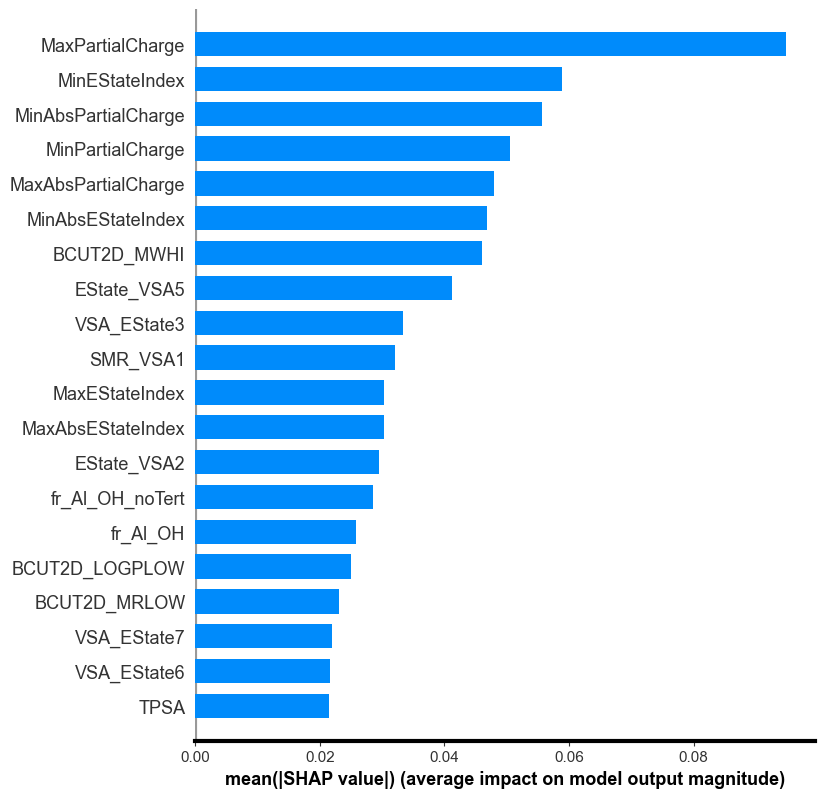

In [19]:
shap.summary_plot(shap_values, X_train, plot_type="bar")



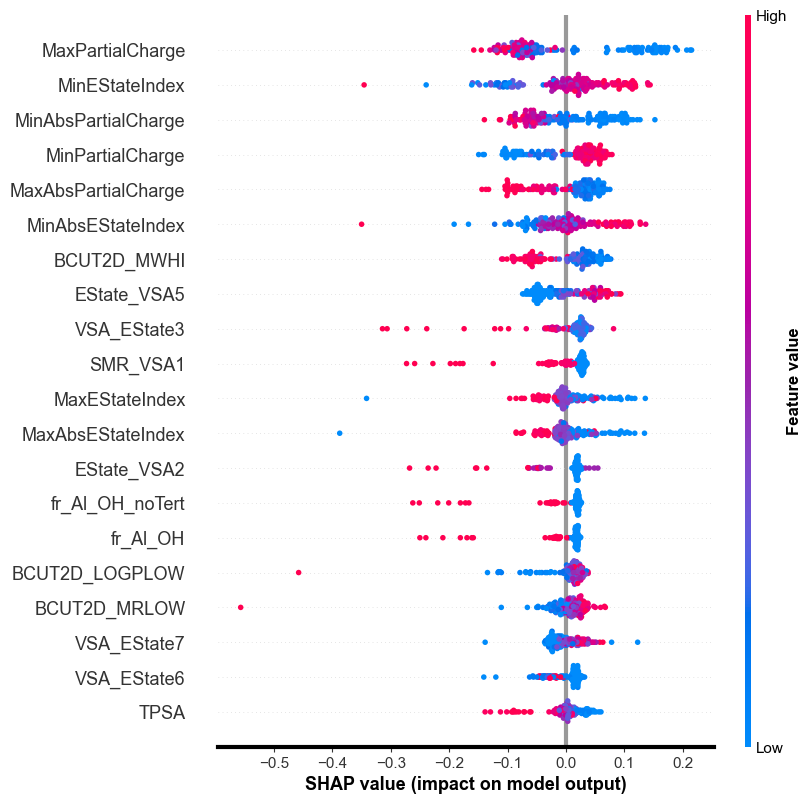

In [20]:
shap.summary_plot(shap_values, X_train)




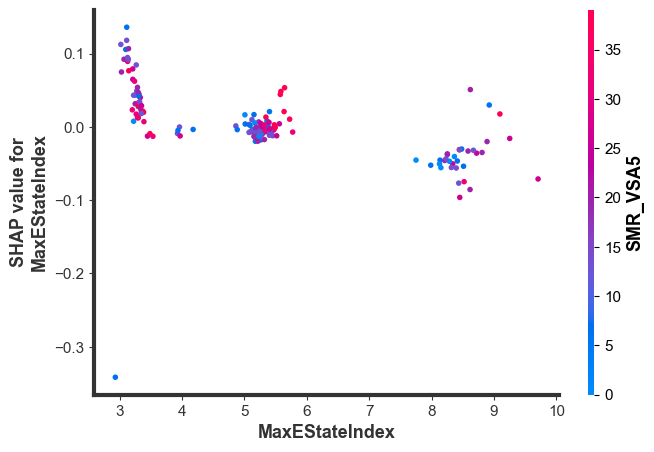

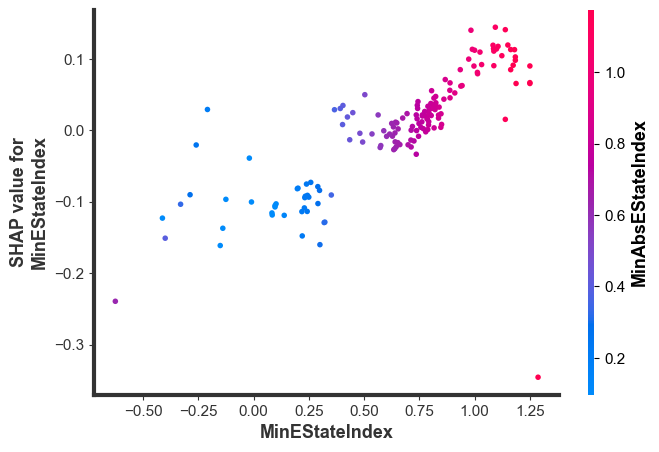

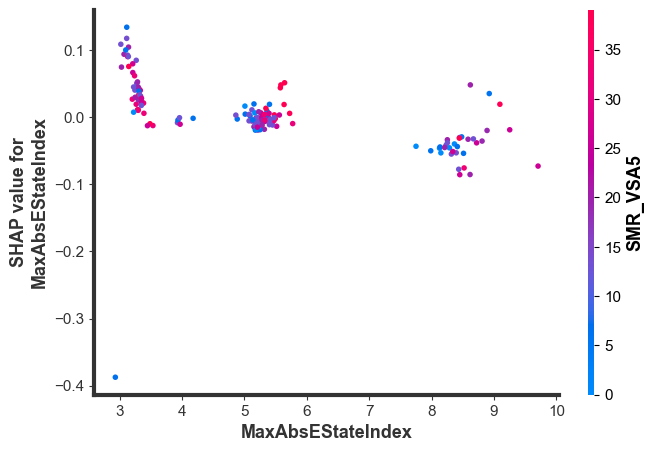

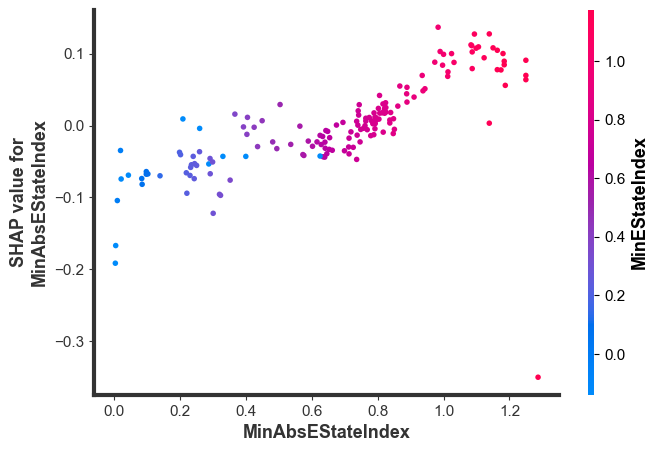

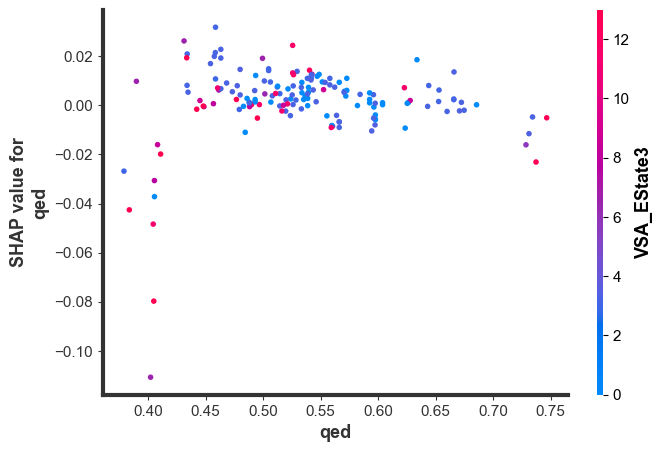

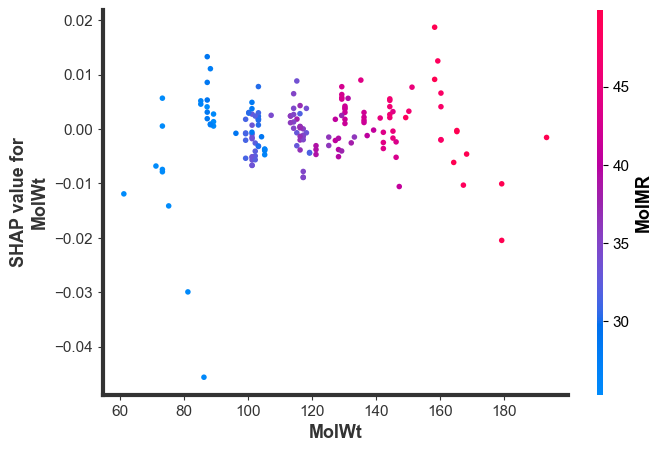

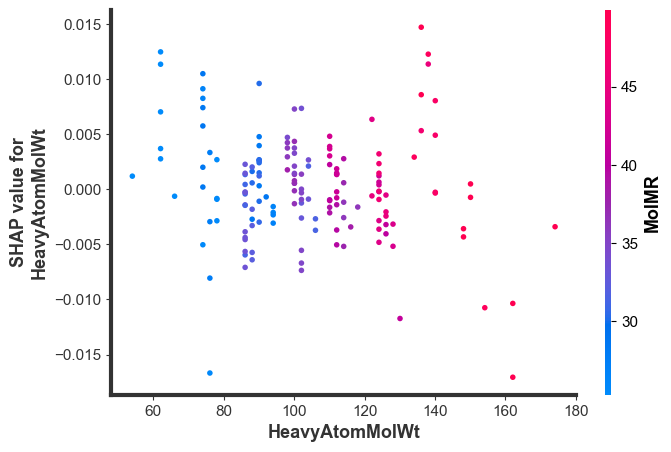

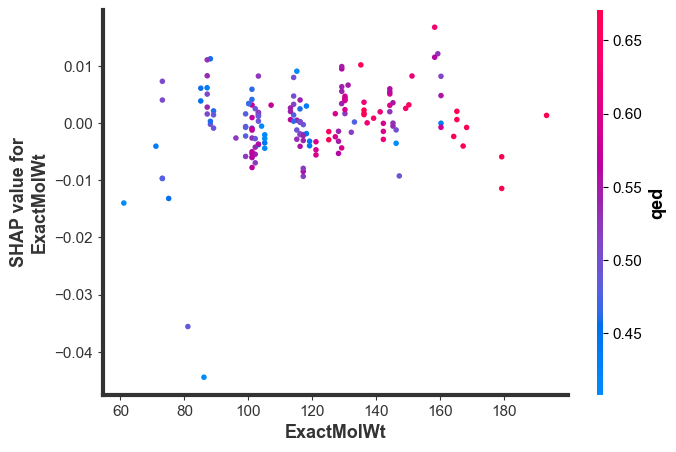

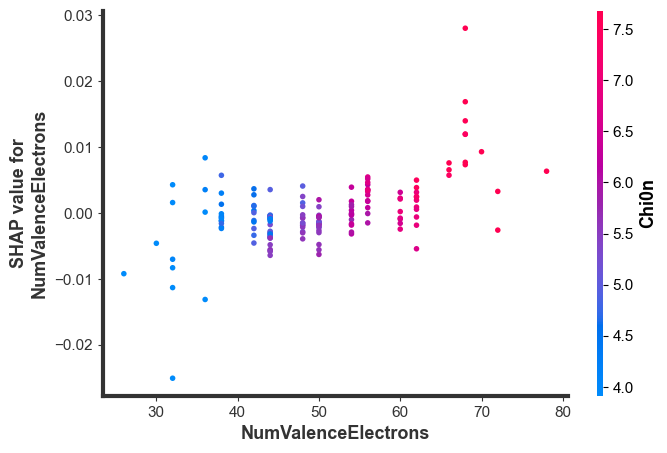

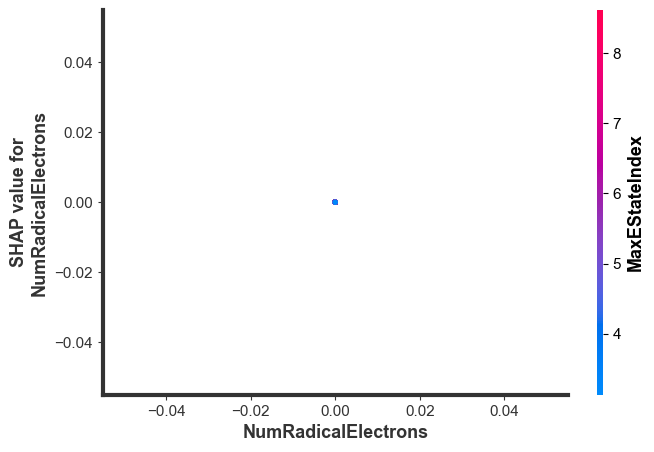

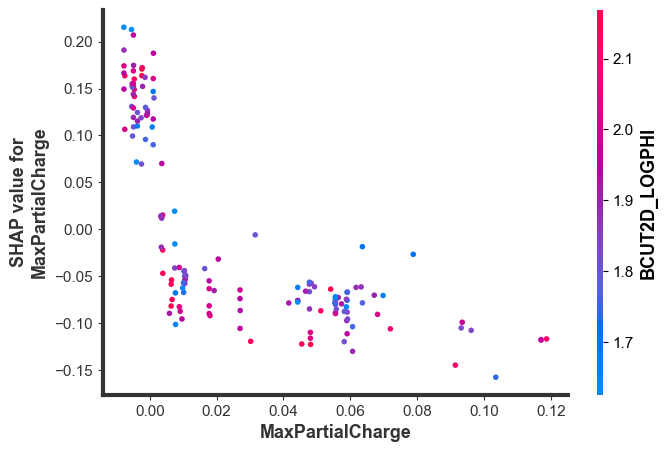

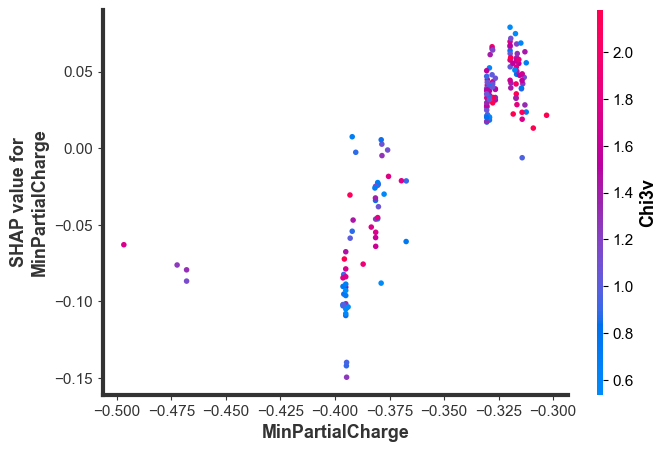

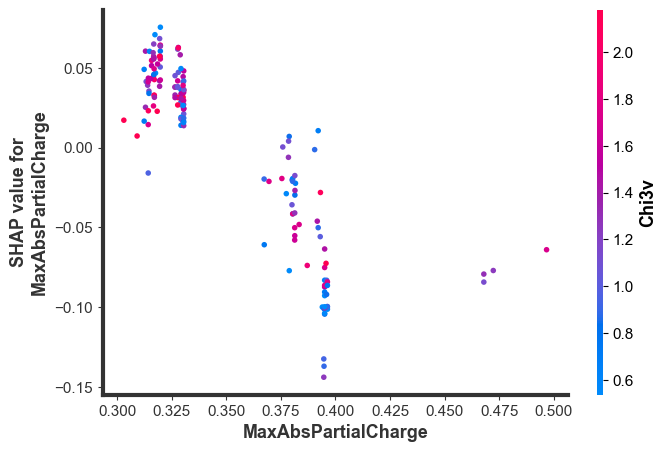

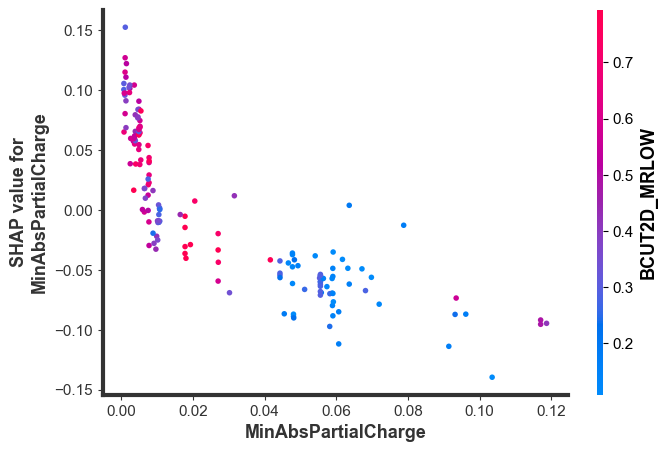

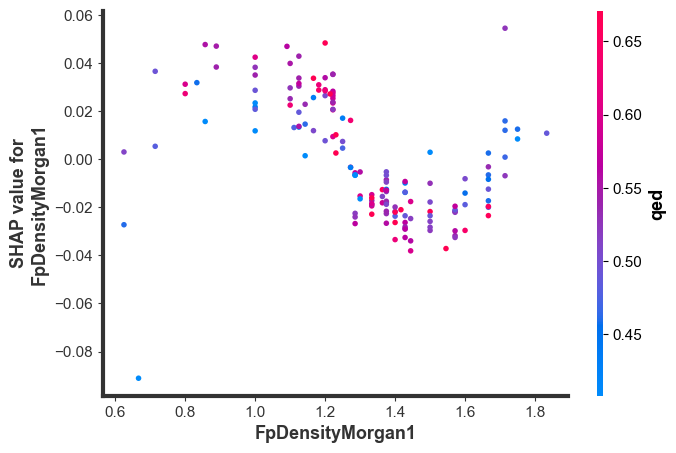

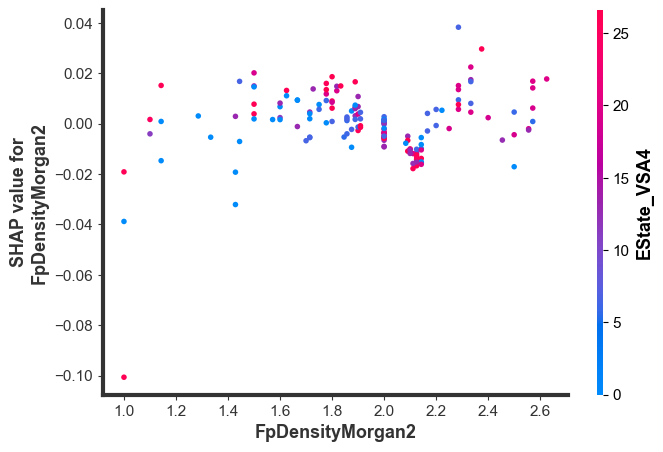

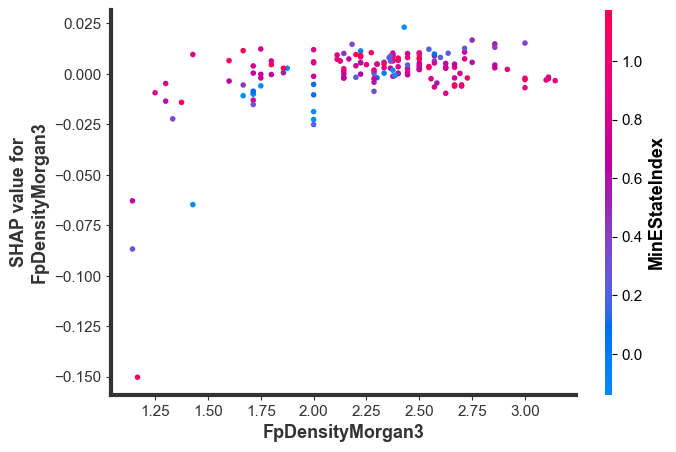

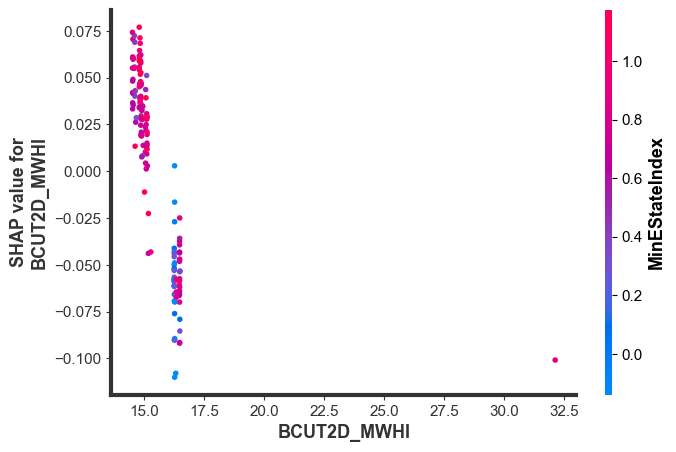

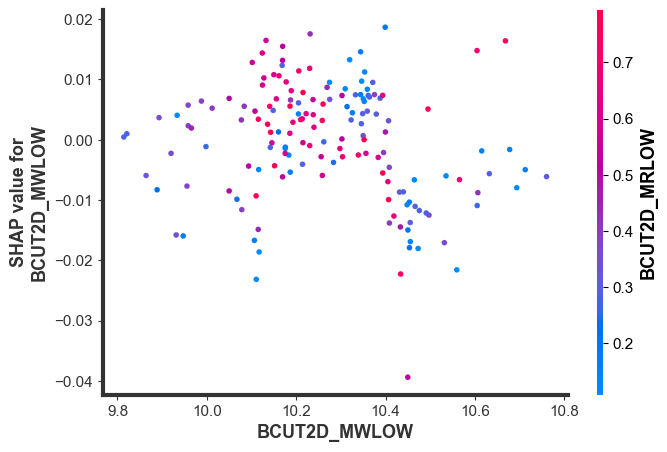

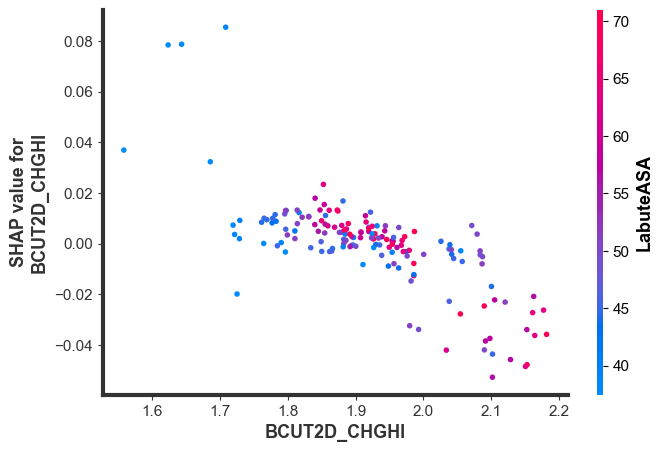

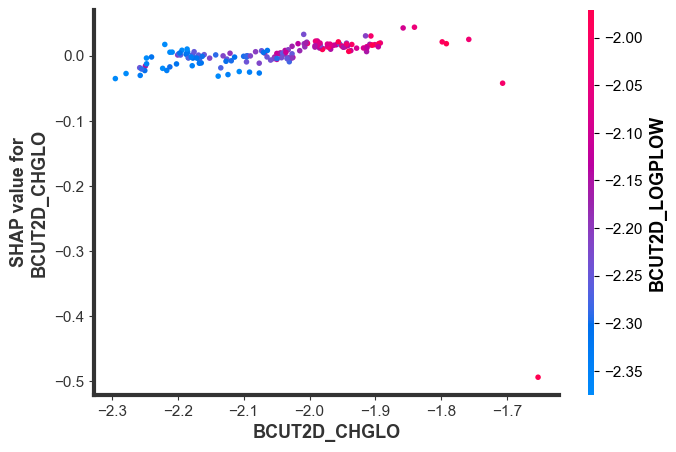

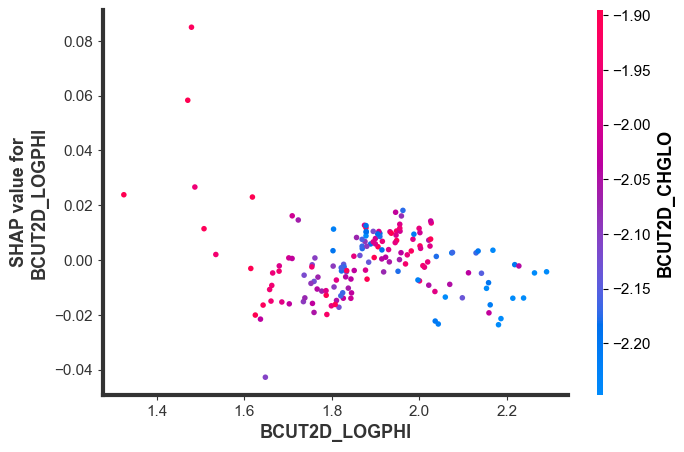

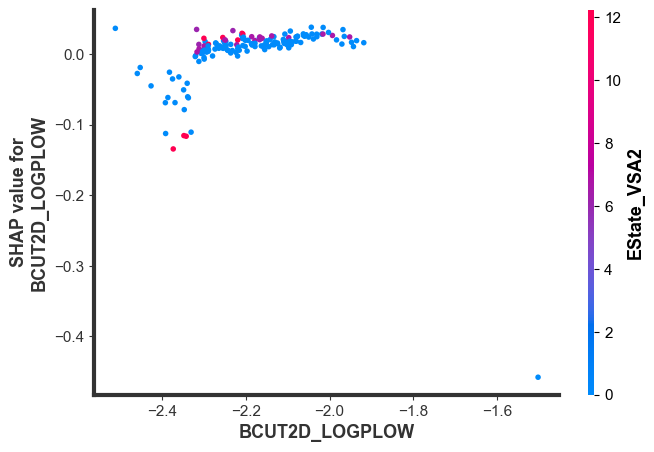

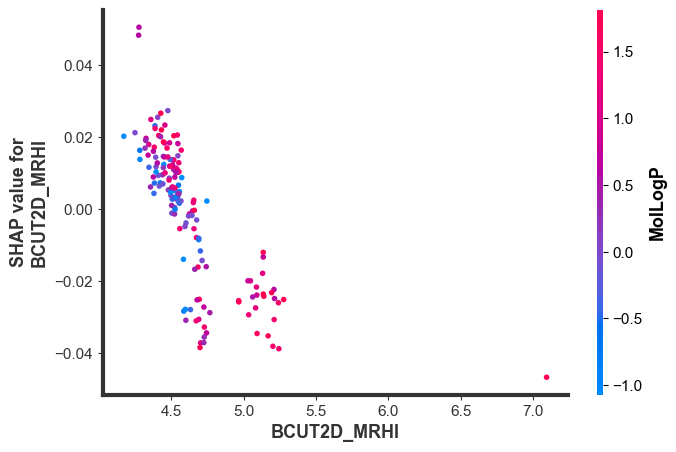

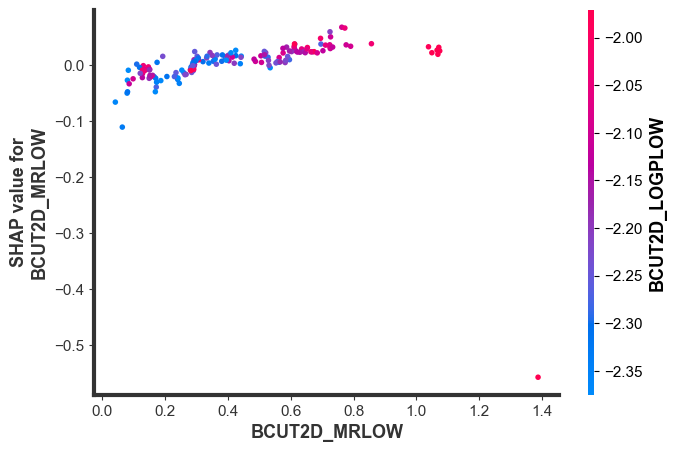

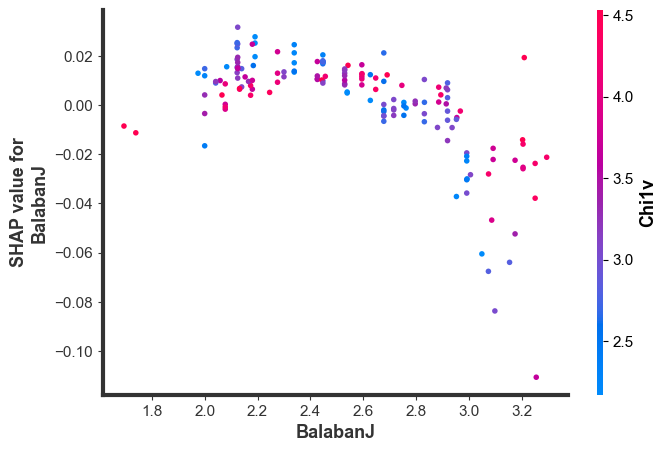

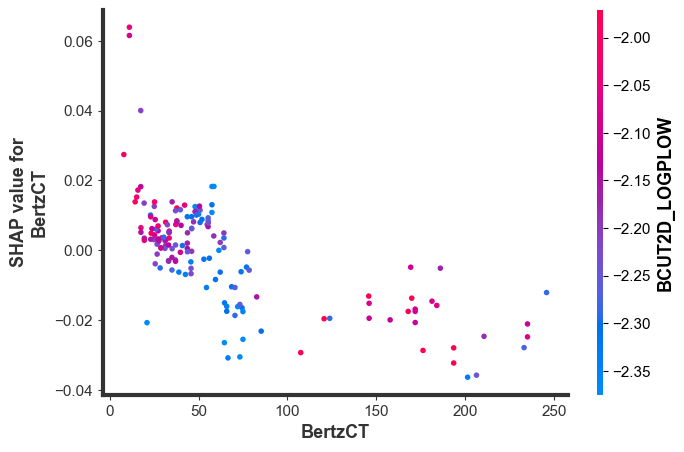

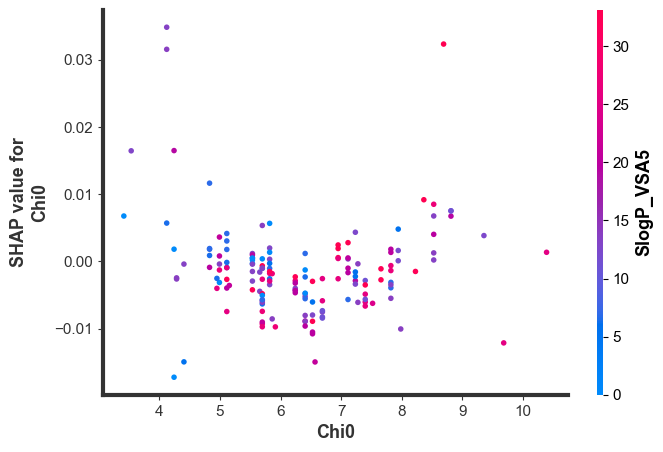

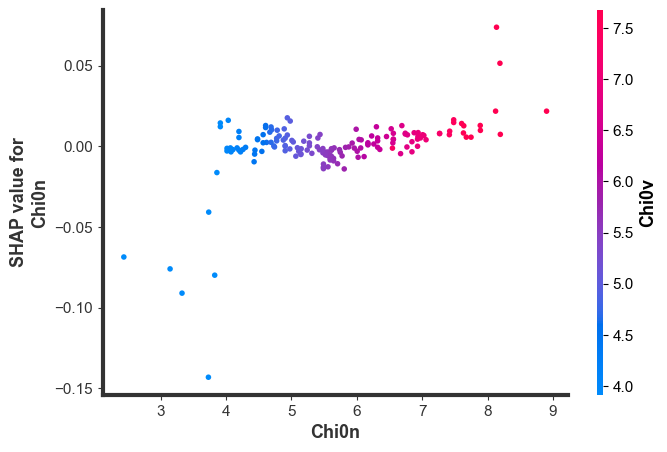

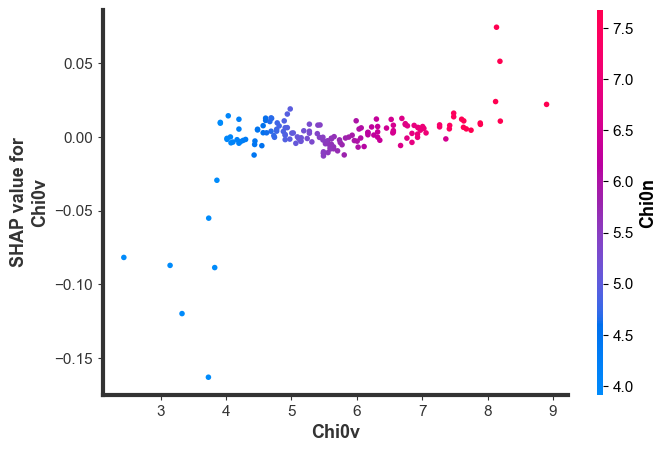

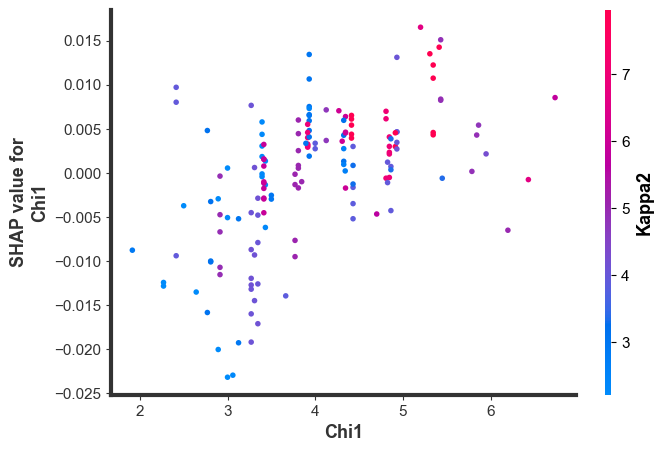

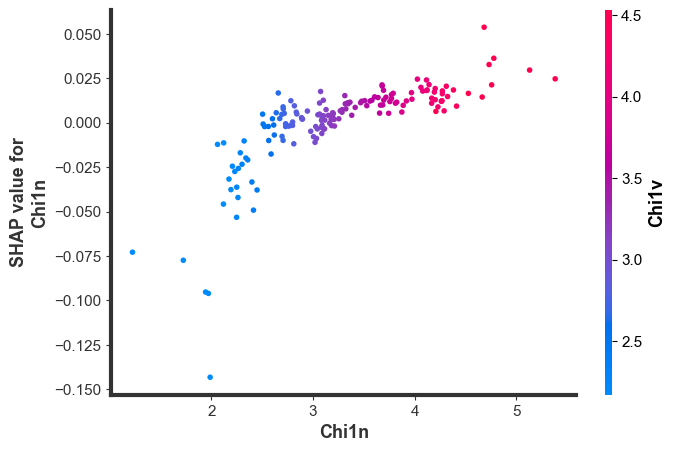

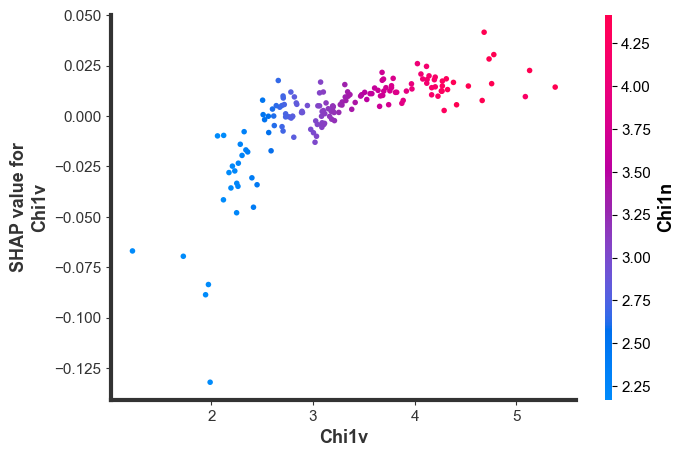

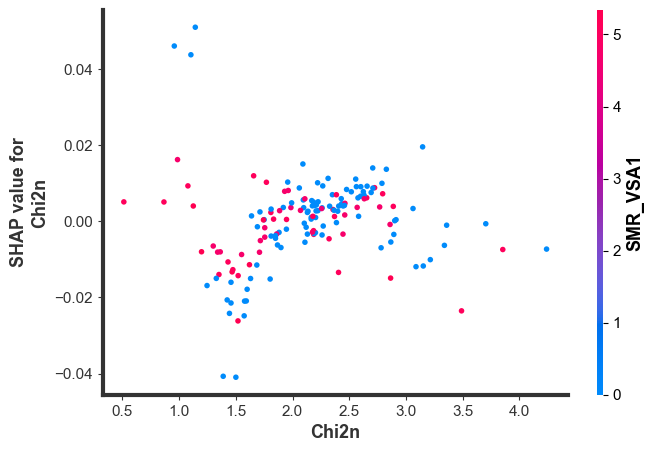

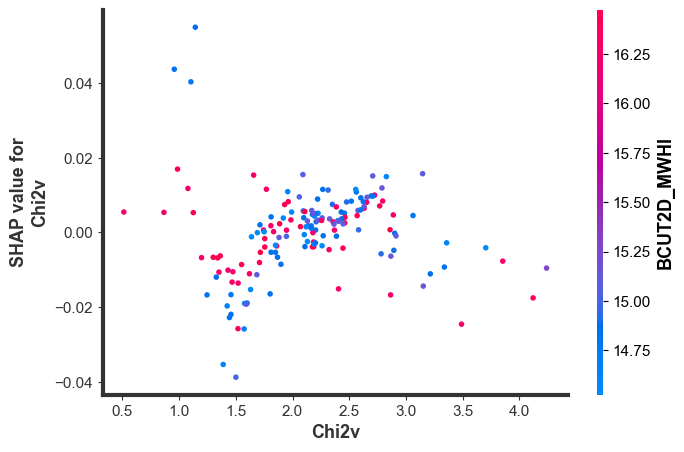

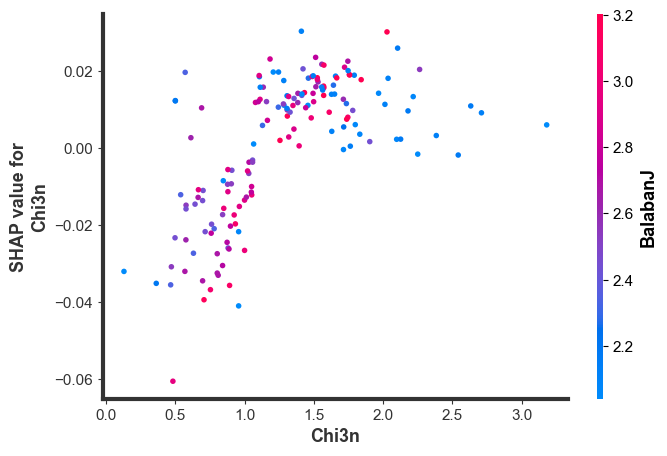

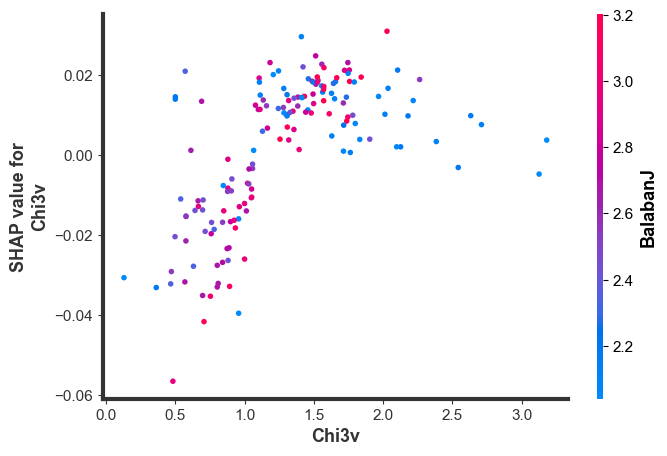

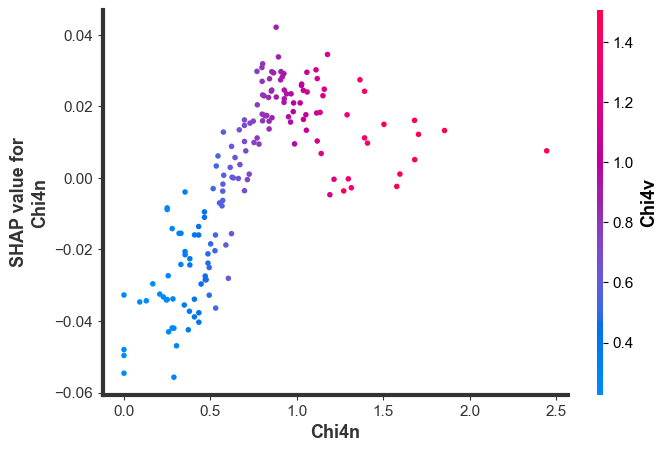

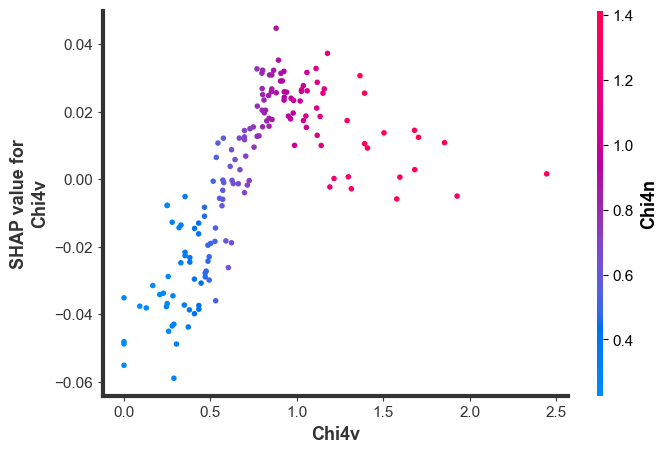

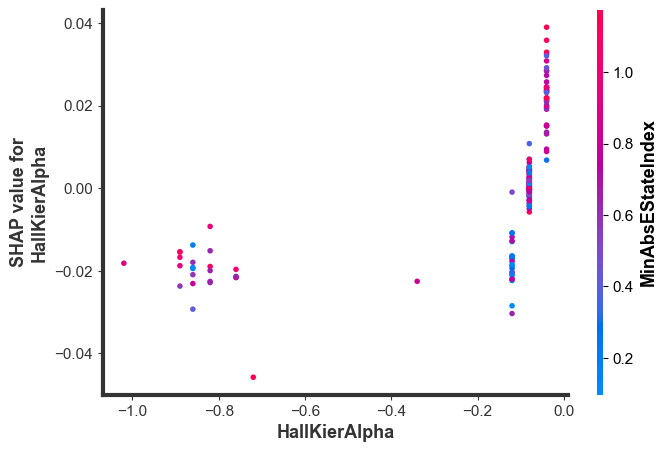

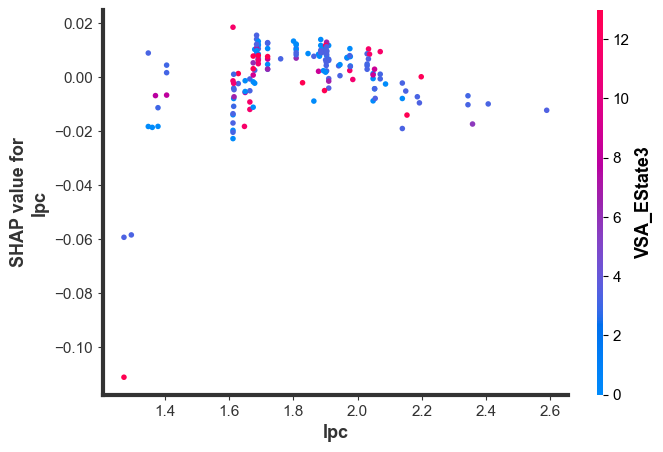

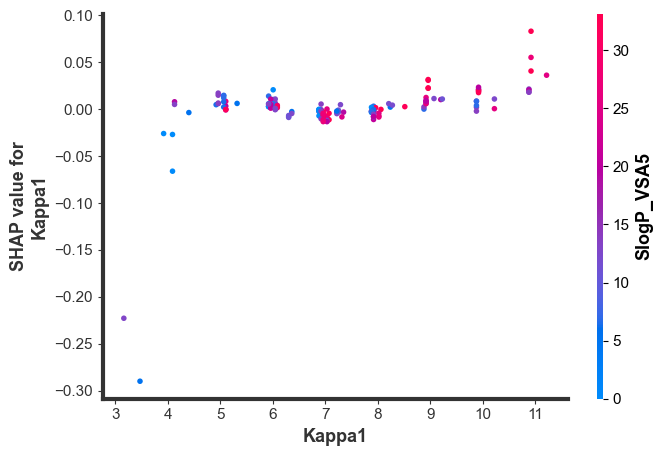

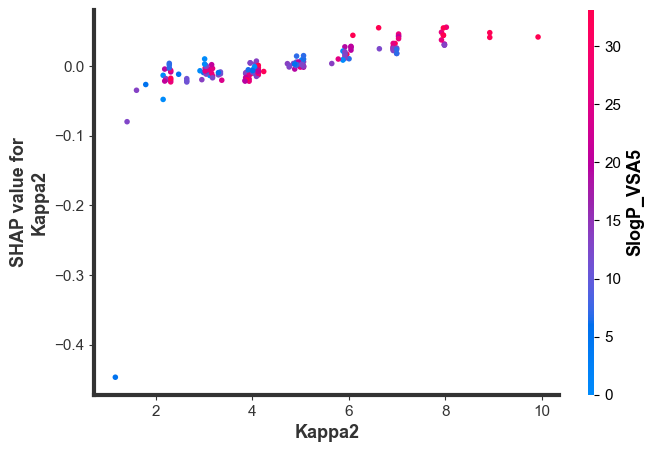

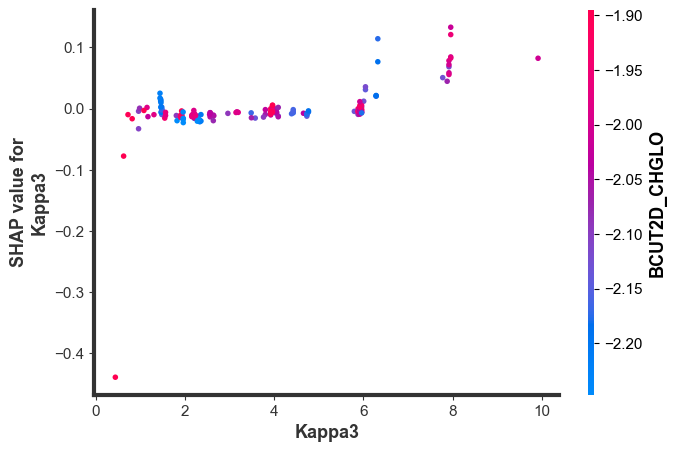

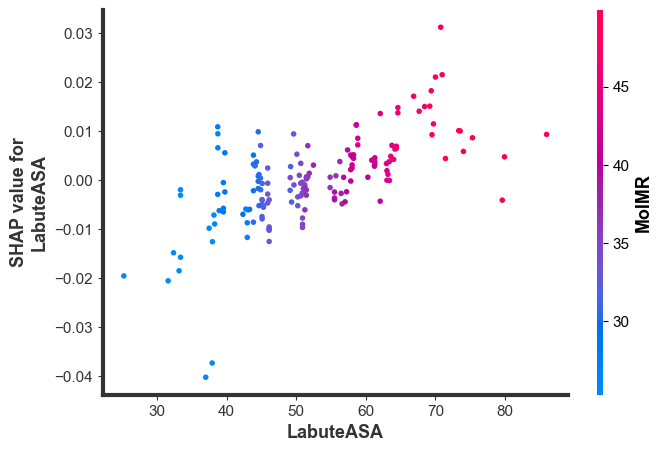

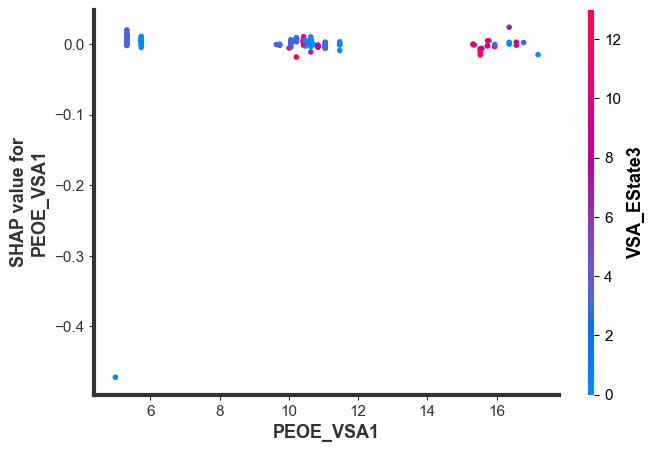

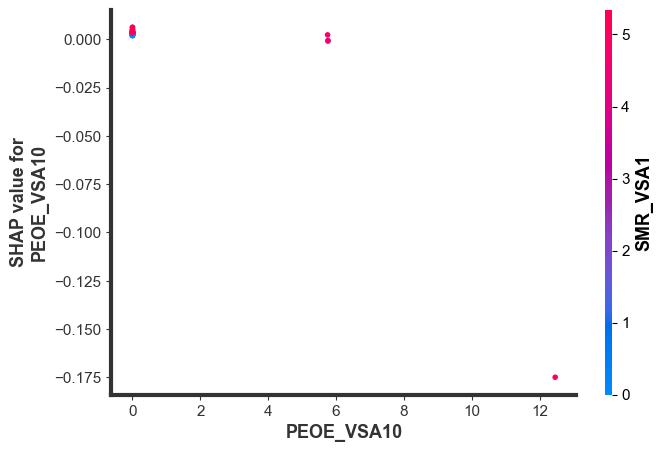

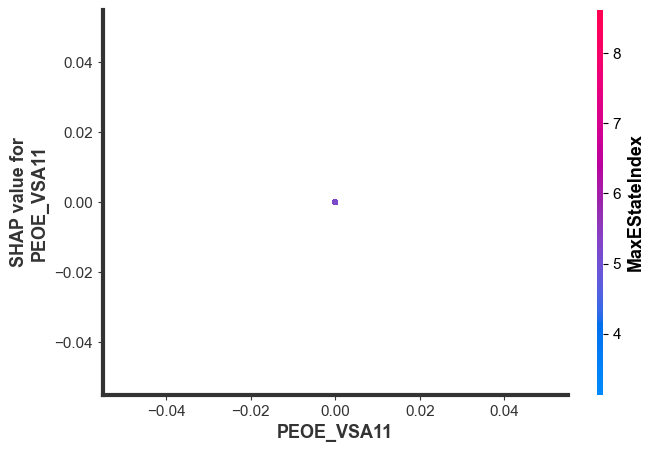

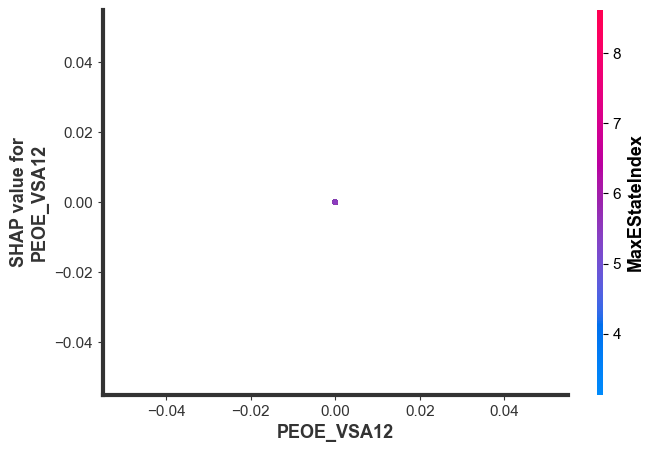

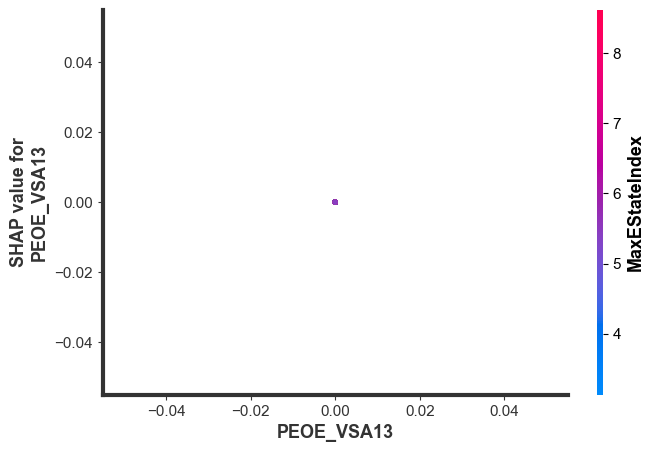

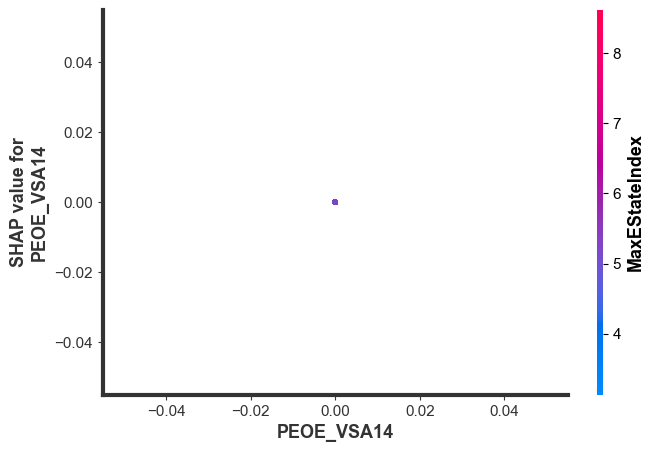

In [33]:

index = 0

for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_train)
    index += 1
    if index > 50:
        break


In [32]:
target_data = data['y']
# 最大
largest_item = target_data[target_data == target_data.max()].index[0]
# 最小
minest_item = target_data[target_data == target_data.min()].index[0]
# np.where(train_dataset['MeSH'] == 100)

In [23]:
max_diff_in_good_situation = 0
error_array = abs(y_train - model_xgb.predict(X_train))
worst_iloc_in_good_situation = 0
for i in range(len(y_train)):
    if error_array[i] > max_diff_in_good_situation and y_train[i] > 0.6:
        max_diff_in_good_situation = error_array[i]


for i in range(len(y_train)):
    if abs(error_array[i] - max_diff_in_good_situation) <= 0.0001:
        worst_iloc_in_good_situation=i
        
print(y_train[worst_iloc_in_good_situation])
print(model_xgb.predict(X_train)[worst_iloc_in_good_situation])

print(X_train.iloc[worst_iloc_in_good_situation])

-5.285483196
-5.5901421305234615
MaxEStateIndex       3.271991
MinEStateIndex       0.935185
MaxAbsEStateIndex    3.271991
MinAbsEStateIndex    0.935185
qed                  0.454315
                       ...   
fr_thiazole          0.000000
fr_thiocyan          0.000000
fr_thiophene         0.000000
fr_unbrch_alkane     0.000000
fr_urea              0.000000
Name: CC1CCNC1, Length: 208, dtype: float64


In [24]:
max_diff = abs(y_train - model_xgb.predict(X_train)).max()
error_array = abs(y_train - model_xgb.predict(X_train))
worst_iloc=-1
for i in range(len(y_train)):
    if abs(error_array[i] - max_diff) <= 0.0001:
        worst_iloc=i
        
# print(y_train[worst_iloc])
# print(model_xgb.predict(X_train)[worst_iloc])

print(X_train.iloc[worst_iloc])

MaxEStateIndex       2.929398
MinEStateIndex       1.287037
MaxAbsEStateIndex    2.929398
MinAbsEStateIndex    1.287037
qed                  0.484507
                       ...   
fr_thiazole          0.000000
fr_thiocyan          0.000000
fr_thiophene         0.000000
fr_unbrch_alkane     0.000000
fr_urea              0.000000
Name: CC1=CNC=C1, Length: 208, dtype: float64


In [25]:
min_diff = abs(y_train - model_xgb.predict(X_train)).min()
best_iloc=-1
for i in range(len(y_train)):
    if abs(error_array[i] - min_diff) <= 0.0001:
        best_iloc=i
        
print(y_train[best_iloc])
print(model_xgb.predict(X_train)[best_iloc])

print(data.iloc[best_iloc])

-8.644373355
-8.642116131086517
MaxEStateIndex       8.127066
MinEStateIndex       0.083333
MaxAbsEStateIndex    8.127066
MinAbsEStateIndex    0.083333
qed                  0.448619
                       ...   
fr_thiocyan          0.000000
fr_thiophene         0.000000
fr_unbrch_alkane     2.000000
fr_urea              0.000000
y                   -8.644373
Name: C(COCCO)N, Length: 209, dtype: float64


MaxEStateIndex       8.127066
MinEStateIndex       0.083333
MaxAbsEStateIndex    8.127066
MinAbsEStateIndex    0.083333
qed                  0.448619
                       ...   
fr_thiazole          0.000000
fr_thiocyan          0.000000
fr_thiophene         0.000000
fr_unbrch_alkane     2.000000
fr_urea              0.000000
Name: C(COCCO)N, Length: 208, dtype: float64
-8.644373355


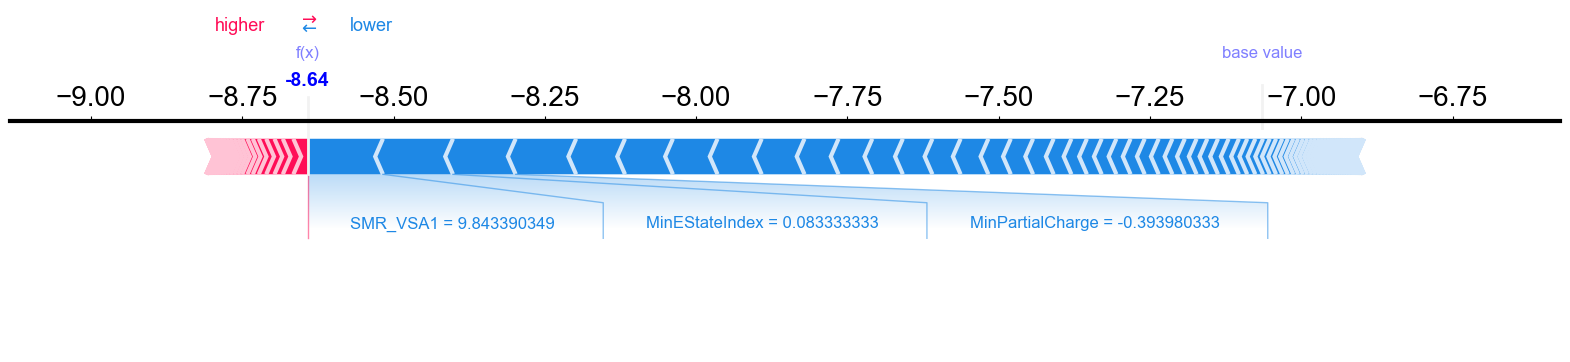

In [26]:
mpl.rcParams['font.size'] = 20

# 最大的值
shap.initjs()
print(train_dataset[feature_column].iloc[best_iloc])
print(train_dataset['y'].iloc[best_iloc])
shap.force_plot(explainer.expected_value, shap_values[best_iloc], train_dataset[feature_column].iloc[best_iloc],matplotlib=True) 

shap.force_plot(explainer.expected_value, shap_values[best_iloc], train_dataset[feature_column].iloc[best_iloc])


MaxEStateIndex       8.127066
MinEStateIndex       0.083333
MaxAbsEStateIndex    8.127066
MinAbsEStateIndex    0.083333
qed                  0.448619
                       ...   
fr_thiazole          0.000000
fr_thiocyan          0.000000
fr_thiophene         0.000000
fr_unbrch_alkane     2.000000
fr_urea              0.000000
Name: C(COCCO)N, Length: 208, dtype: float64
-8.644373355


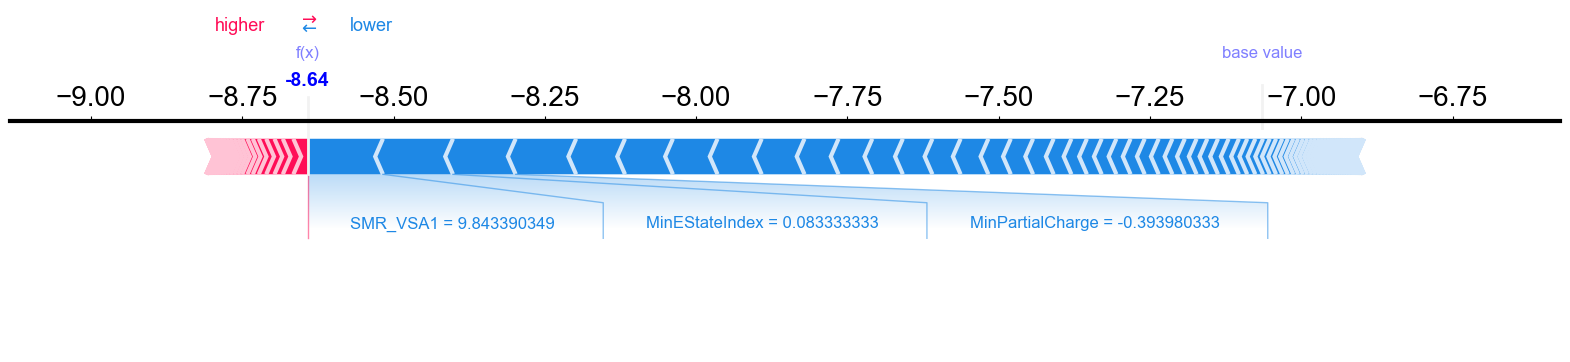

In [27]:
shap.initjs()
print(train_dataset[feature_column].iloc[best_iloc])
print(train_dataset['y'].iloc[best_iloc])

shap.force_plot(explainer.expected_value, shap_values[best_iloc], train_dataset[feature_column].iloc[best_iloc])
shap.force_plot(explainer.expected_value, shap_values[best_iloc], train_dataset[feature_column].iloc[best_iloc],matplotlib=True)

MaxEStateIndex       2.929398
MinEStateIndex       1.287037
MaxAbsEStateIndex    2.929398
MinAbsEStateIndex    1.287037
qed                  0.484507
                       ...   
fr_thiazole          0.000000
fr_thiocyan          0.000000
fr_thiophene         0.000000
fr_unbrch_alkane     0.000000
fr_urea              0.000000
Name: CC1=CNC=C1, Length: 208, dtype: float64


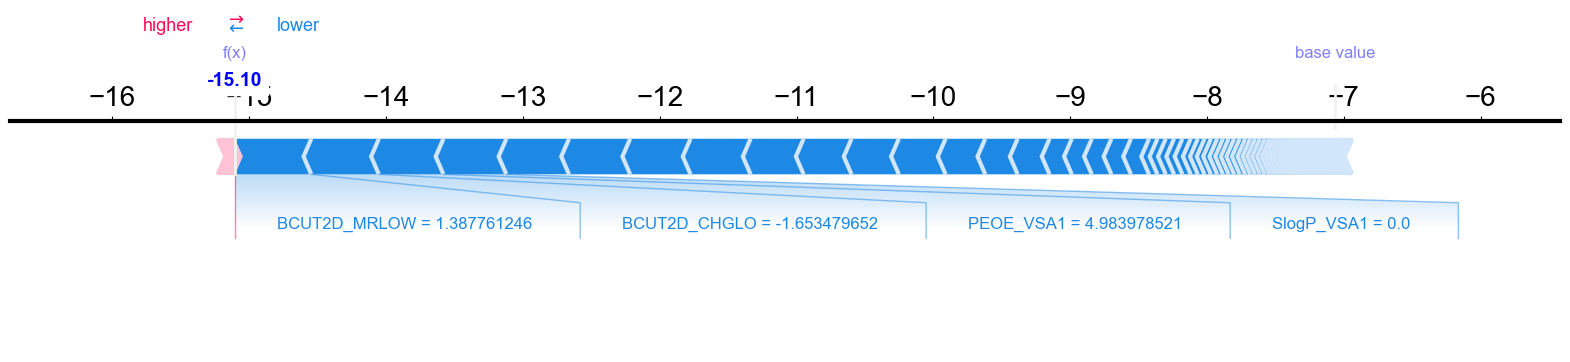

In [28]:
shap.initjs()
print(train_dataset[feature_column].iloc[worst_iloc])
shap.force_plot(explainer.expected_value, shap_values[worst_iloc], train_dataset[feature_column].iloc[worst_iloc])
shap.force_plot(explainer.expected_value, shap_values[worst_iloc], train_dataset[feature_column].iloc[worst_iloc],matplotlib=True)


MaxEStateIndex       3.271991
MinEStateIndex       0.935185
MaxAbsEStateIndex    3.271991
MinAbsEStateIndex    0.935185
qed                  0.454315
                       ...   
fr_thiazole          0.000000
fr_thiocyan          0.000000
fr_thiophene         0.000000
fr_unbrch_alkane     0.000000
fr_urea              0.000000
Name: CC1CCNC1, Length: 208, dtype: float64
-5.285483196


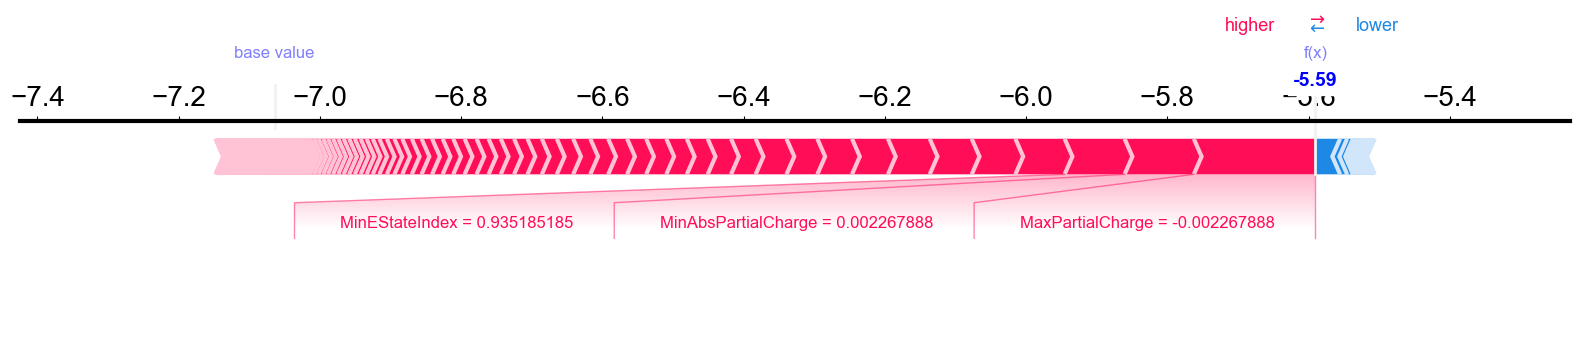

In [29]:

shap.initjs()
print(train_dataset[feature_column].iloc[worst_iloc_in_good_situation])
print(train_dataset['y'].iloc[worst_iloc_in_good_situation])
shap.force_plot(explainer.expected_value, shap_values[worst_iloc_in_good_situation], train_dataset[feature_column].iloc[worst_iloc_in_good_situation],matplotlib=True) 
shap.force_plot(explainer.expected_value, shap_values[worst_iloc_in_good_situation], train_dataset[feature_column].iloc[worst_iloc_in_good_situation]) 



In [30]:
# train_dataset[feature_column].loc["C1CNCCC1CN"]


MaxEStateIndex       8.127066
MinEStateIndex       0.083333
MaxAbsEStateIndex    8.127066
MinAbsEStateIndex    0.083333
qed                  0.448619
                       ...   
fr_thiazole          0.000000
fr_thiocyan          0.000000
fr_thiophene         0.000000
fr_unbrch_alkane     2.000000
fr_urea              0.000000
Name: C(COCCO)N, Length: 208, dtype: float64
-8.644373355


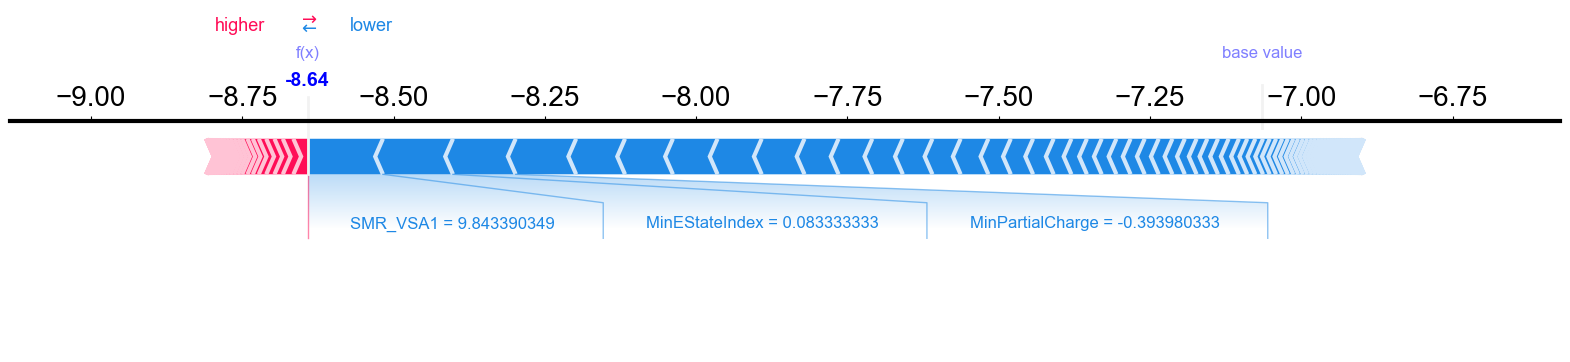

In [31]:
iloc = best_iloc
shap.initjs()
print(train_dataset[feature_column].iloc[iloc])
print(train_dataset['y'].iloc[iloc])
shap.force_plot(explainer.expected_value, shap_values[iloc], train_dataset[feature_column].iloc[iloc],matplotlib=True) 
shap.force_plot(explainer.expected_value, shap_values[iloc], train_dataset[feature_column].iloc[iloc]) 
